<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Get-the-tiff-files-and-calculate-band-5-reflectance" data-toc-modified-id="Get-the-tiff-files-and-calculate-band-5-reflectance-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Get the tiff files and calculate band 5 reflectance</a></span></li><li><span><a href="#Save-the-crs-and-the-map_transform" data-toc-modified-id="Save-the-crs-and-the-map_transform-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Save the crs and the map_transform</a></span></li><li><span><a href="#Locate-UBC-on-the-map" data-toc-modified-id="Locate-UBC-on-the-map-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Locate UBC on the map</a></span></li><li><span><a href="#Locate-UBC-on-the-image" data-toc-modified-id="Locate-UBC-on-the-image-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Locate UBC on the image</a></span></li><li><span><a href="#Plot-the-raw-band-5-image-in-grey,-clipped-to-reflectivities-below-0.6" data-toc-modified-id="Plot-the-raw-band-5-image-in-grey,-clipped-to-reflectivities-below-0.6-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Plot the raw band 5 image in grey, clipped to reflectivities below 0.6</a></span></li><li><span><a href="#Use-a-rasterio-window-to-write-a-new-tiff-file" data-toc-modified-id="Use-a-rasterio-window-to-write-a-new-tiff-file-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Use a rasterio window to write a new tiff file</a></span></li><li><span><a href="#Make-the-new-affine-transform" data-toc-modified-id="Make-the-new-affine-transform-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Make the new affine transform</a></span></li><li><span><a href="#Now-write-this-out-to-small_file.tiff" data-toc-modified-id="Now-write-this-out-to-small_file.tiff-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Now write this out to small_file.tiff</a></span></li><li><span><a href="#Put-this-on-a-cartopy-map" data-toc-modified-id="Put-this-on-a-cartopy-map-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Put this on a cartopy map</a></span></li><li><span><a href="#Higher-resolution-coastline" data-toc-modified-id="Higher-resolution-coastline-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>Higher resolution coastline</a></span></li></ul></div>

# Introduction

We need to be able to select a small region of a landsat image to work with.  This notebook 

1. zooms in on a 200 pixel x 200 pixel subscene centered on the UBC Vancouver campus using pyproj an affine transform to map from lat,lon to x,y in UTM zone 10N to row, column in the landsat image

2. Uses a rasterio window to calculate the new affine transform for that subscene 

3. writes the subscene  out to a much smaller tiff file.

4. plots the subscene on a cartopy map and marks the center with a red dot

5. reads in a coastline from the openstreetmaps project and plots that.

In [1]:
import rasterio
import a301
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cartopy
from rasterio.windows import Window
from pyproj import transform as proj_transform
from pyproj import Proj
from a301.landsat.toa_reflectance import toa_reflectance_8
import pprint

filenames=["LC08_L1TP_047026_20150614_20180131_01_T1_B4.TIF",
    "LC08_L1TP_047026_20150614_20180131_01_T1_B5.TIF",
    "LC08_L1TP_047026_20150614_20180131_01_T1_MTL.txt"]
dest_folder=a301.data_dir / Path("landsat8/vancouver")

# Get the tiff files and calculate band 5 reflectance

In [2]:
band2=list(dest_folder.glob("*_B2.TIF"))[0]
band3=list(dest_folder.glob("*_B3.TIF"))[0]
band4=list(dest_folder.glob("*_B4.TIF"))[0]
band5=list(dest_folder.glob("*_B5.TIF"))[0]
mtl_file=list(dest_folder.glob("*MTL.txt"))[0]

# Save the crs and the map_transform

We need to keep both map_transform (the affine transform for the full scened, and the projection transform from pyproj (called proj_transform below)

Scene LC80470262015165LGN02 center time is 2015-06-14 19:00:43


Text(0.5,1,'band 5 reflectance whole scene')

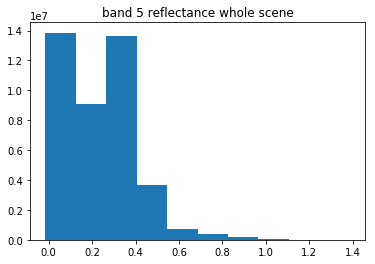

In [38]:
with rasterio.open(band5) as b5_raster:
    map_transform=b5_raster.transform
    crs=b5_raster.crs
    profile=b5_raster.profile
    refl=toa_reflectance_8([5],mtl_file)
    b5_refl=refl[5]
plt.hist(b5_refl[~np.isnan(b5_refl)].flat)
plt.title('band 5 reflectance whole scene')

In [4]:
print(f"profile: \n{pprint.pformat(profile)}")

profile: 
{'blockxsize': 256,
 'blockysize': 256,
 'compress': 'lzw',
 'count': 1,
 'crs': CRS({'init': 'epsg:32610'}),
 'driver': 'GTiff',
 'dtype': 'uint16',
 'height': 7961,
 'interleave': 'band',
 'nodata': None,
 'tiled': True,
 'transform': Affine(30.0, 0.0, 397185.0,
       0.0, -30.0, 5531415.0),
 'width': 7851}


# Locate UBC on the map

We need to project the center of campus from lon/lat to UTM 10N x,y using pyproj.transform

In [5]:
p_utm = Proj(crs)
p_latlon=Proj(proj='latlong',datum='WGS84')
ubc_lon = -123.2460
ubc_lat = 49.2606
ubc_x, ubc_y =proj_transform(p_latlon,p_utm,ubc_lon, ubc_lat) 

# Locate UBC on the image

Now we need to use the affine transform to go between x,y and 
col, row on the image.  The next cell creates two slice objects that extend 100 pixels on either side of the center point.  The tilde (~) in front of the transform indicates that we're going from x,y to col,row, instead of col,row to x,y.  (See [this blog entry](http://www.perrygeo.com/python-affine-transforms.html) for reference.)

In [24]:
ubc_row, ubc_col = ~map_transform*(ubc_x,ubc_y)
ubc_row, ubc_col = int(ubc_row), int(ubc_col)
x_slice=slice(ubc_col-100,ubc_col+100)
y_slice=slice(ubc_row - 100, ubc_row + 100)
section=b5_refl[x_slice,y_slice]
x_slice,y_slice

(slice(2398, 2598, None), slice(2730, 2930, None))

# Plot the raw band 5 image in grey, clipped to reflectivities below 0.6

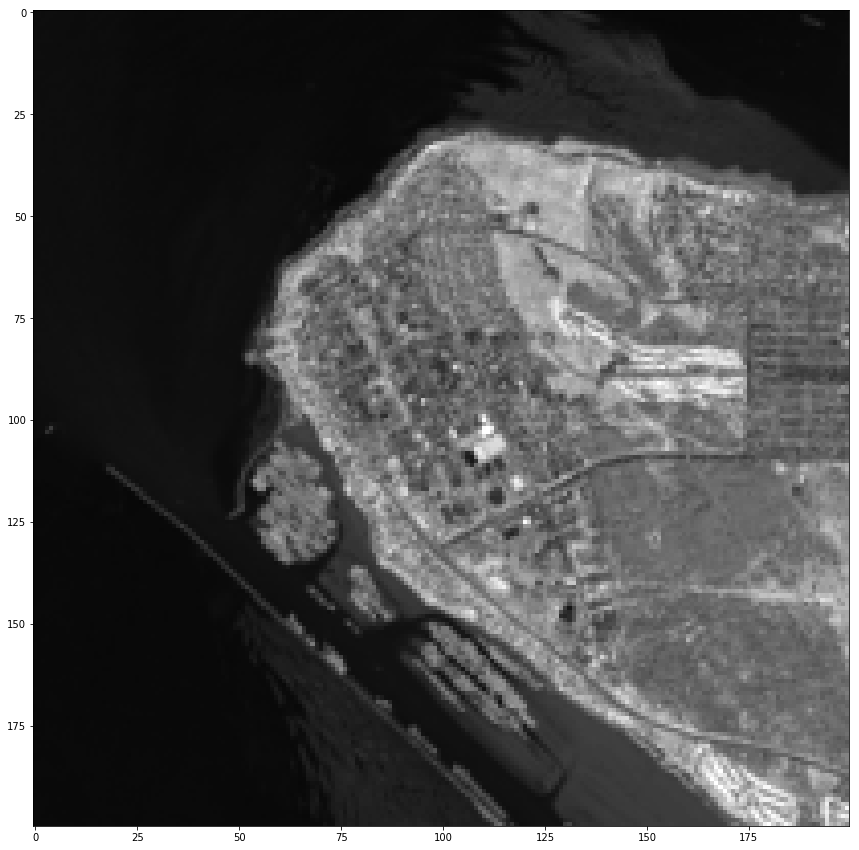

In [25]:
vmin=0.0
vmax=0.6
the_norm=Normalize(vmin=vmin,vmax=vmax,clip=False)
palette='gray'
pal = plt.get_cmap(palette)
pal.set_bad('0.75') #75% grey for out-of-map cells
pal.set_over('w')  #color cells > vmax red
pal.set_under('k')  #color cells < vmin black
fig, ax = plt.subplots(1,1,figsize=(15,15))
ax.imshow(section,cmap=pal,norm=the_norm);

# Use a rasterio window to write a new tiff file

The [window module](https://rasterio.readthedocs.io/en/latest/topics/windowed-rw.html) has a function that will produce a new affine transform for the subscene.
First we need to add a third dimension to the np.array, because
rasterio expects [band,x,y] for its writer.  Do this with np.newaxis

In [26]:
print(section.shape)
out=section[np.newaxis,...]
print(out.shape)

(200, 200)
(1, 200, 200)


# Make the new affine transform

It will have a new upper left hand corner but the same 30 meter pixel size

In [27]:
the_win=Window(ubc_col-100,ubc_row-100,200,200)
with rasterio.open(band5) as b5_raster:
    b5_data = b5_raster.read(1,window=the_win)
    win_transform = b5_raster.window_transform(the_win)

# Now write this out to small_file.tiff

In [28]:
tif_filename=a301.data_dir / Path('small_file.tiff')    
num_chans=1
with rasterio.open(tif_filename,'w',driver='GTiff',
                   height=the_win.height,width=the_win.width,
                   count=num_chans,dtype=section.dtype,
                   crs=crs,transform=win_transform, nodata=0.0) as dst:
        dst.write(out)
        new_profile=dst.profile
        
print(f"section profile: {pprint.pformat(new_profile)}")

section profile: {'count': 1,
 'crs': CRS({'init': 'epsg:32610'}),
 'driver': 'GTiff',
 'dtype': 'float32',
 'height': 200,
 'interleave': 'band',
 'nodata': 0.0,
 'tiled': False,
 'transform': Affine(30.0, 0.0, 469125.0,
       0.0, -30.0, 5449515.0),
 'width': 200}


# Put this on a cartopy map

We need the extent of the image, which we can get by finding
the corners of the section in x,y coordinates from their
row and column

Mark the center with a 'ro' dot using ax.plot  (coastline doesn't seem to be working at the moment)

In [30]:
xmin,ymin = win_transform*(0,0)        
xmax,ymax = win_transform*(the_win.width,the_win.height)

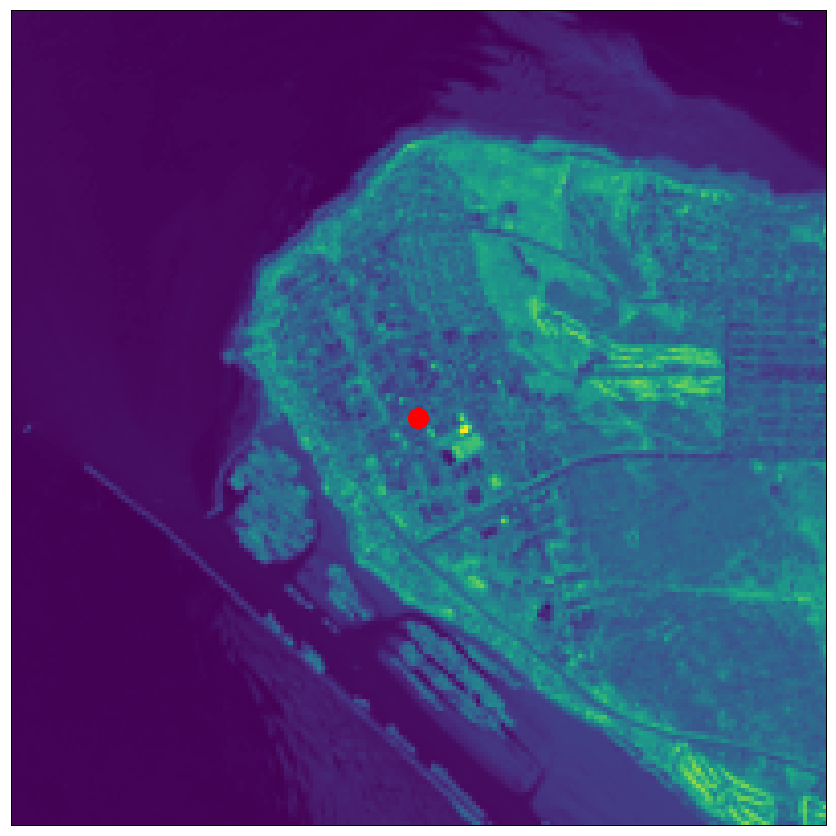

In [39]:
projection=cartopy.crs.epsg(crs.to_epsg())
fig, ax = plt.subplots(1, 1,figsize=[15,15],
                       subplot_kw={'projection': projection})
ax.coastlines(resolution='10m',color='red',lw=20)
ax.imshow(section.squeeze(), origin='lower', 
          extent=[xmin, xmax, ymin, ymax], 
          transform=projection, 
          interpolation='nearest')
ax.plot((xmin+xmax)/2.,(ymin + ymax)/2.,
        'ro',markersize=20,transform=projection)
ax.set_extent([xmin, xmax, ymin, ymax],projection);

# Higher resolution coastline

Here is what Point Grey looks like with the [open street maps](https://automating-gis-processes.github.io/2017/lessons/L7/retrieve-osm-data.html) coastline database

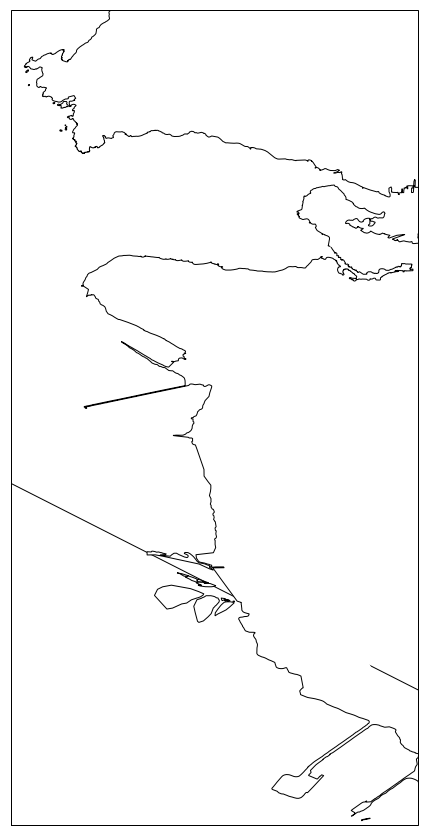

In [13]:
from cartopy.io import shapereader
shape_project=cartopy.crs.PlateCarree()
shp = shapereader.Reader(str(a301.test_dir / 
                             Path("ubc_coastlines/lines.shp")))
fig, ax = plt.subplots(1, 1,figsize=[15,15],
                       subplot_kw={'projection': shape_project})
extent=[-123.3,-123.1,49,49.4]
ax.coastlines()
ax.set_extent(extent)
for record, geometry in zip(shp.records(), shp.geometries()):
    ax.add_geometries([geometry], shape_project, facecolor='w',
                      edgecolor='black')